# CIFAR-10


The CIFAR-10 dataset is a widely used benchmark dataset in the field of machine learning and computer vision. It consists of $60,000$ color images of size $32 \times 32$ in 10 classes, with $6,000$ images per class. The dataset is divided into $50,000$ training images and $10,000$ testing images.

Download an extract the dataset.

In [1]:
!wget https://hyperion.bbirke.de/data/datasets/cifar-10-python.tar.gz
!mkdir -p datasets/cifar-10
!tar -xzf cifar-10-python.tar.gz -C datasets/cifar-10

--2024-03-11 14:53:05--  https://hyperion.bbirke.de/data/datasets/cifar-10-python.tar.gz
Resolving hyperion.bbirke.de (hyperion.bbirke.de)... 45.10.26.122
Connecting to hyperion.bbirke.de (hyperion.bbirke.de)|45.10.26.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  20.2MB/s    in 9.0s    

2024-03-11 14:53:15 (18.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



The archive contains the files `data_batch_1`, `data_batch_2`, ..., `data_batch_5`, as well as `test_batch`. Each of these files is a Python "pickled" object produced with `cPickle`. Here is a function which will open such a file and return a dictionary:

In [2]:
import pickle

def unpickle(file):
    with open(file, 'rb') as fo:
        batch_dict = pickle.load(fo, encoding='bytes')
    return {k.decode("utf-8"): v for k, v in batch_dict.items()}

Loaded in this way, each of the batch files contains a dictionary with the following elements:

* **data** - a $10000 \times 3072$ numpy array of `uint8s`. Each row of the array stores a $32 \times 32$ colour image. The first $1024$ entries contain the red channel values, the next $1024$ the green, and the final $1024$ the blue. The image is stored in row-major order, so that the first $32$ entries of the array are the red channel values of the first row of the image.
* **labels** - a list of $10000$ numbers in the range $[0, 9]$. The number at index $i$ indicates the label of the $i$th image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* **label_names** - a $10$-element list which gives meaningful names to the numeric labels in the labels array described above. For example, `label_names[0] == "airplane"`, `label_names[1] == "automobile"`, etc.

In [3]:
label_names = unpickle("datasets/cifar-10/cifar-10-batches-py/batches.meta")['label_names']
val2label = {i: name.decode("utf-8") for i, name in enumerate(label_names)}

for i in range(len(val2label)):
    print(f"label idx: {i} label: {val2label[i]}")

label idx: 0 label: airplane
label idx: 1 label: automobile
label idx: 2 label: bird
label idx: 3 label: cat
label idx: 4 label: deer
label idx: 5 label: dog
label idx: 6 label: frog
label idx: 7 label: horse
label idx: 8 label: ship
label idx: 9 label: truck


## Your Task

Your task is to train a model and (hopefully) predict an image of Lilo as a cat. You can get a $32 \times 32$ pixel color image with the following command.

In [4]:
!wget https://raw.githubusercontent.com/bbirke/ml-python/main/images/lilo_small.png -O lilo_small.png

--2024-03-11 14:53:22--  https://raw.githubusercontent.com/bbirke/ml-python/main/images/lilo_small.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1679 (1.6K) [image/png]
Saving to: ‘lilo_small.png’

lilo_small.png      100%[===================>]   1.64K  --.-KB/s    in 0s      

2024-03-11 14:53:22 (28.8 MB/s) - ‘lilo_small.png’ saved [1679/1679]



We define our Datasets.

In [5]:
from torch.utils.data import Dataset
import pickle
import numpy as np

class CifarDataset(Dataset):
    def __init__(self, paths, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform

        label = []
        image = []

        for p in paths:
            batch = self.__unpickle__(p)
            label.append(np.array(batch[b'labels']))
            image.append(batch[b'data'])

        self.labels = np.concatenate(label)
        self.images = np.moveaxis(np.concatenate(image).
                                  reshape(-1, 3, 32, 32), 1, -1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    def __unpickle__(self, file):
        with open(file, 'rb') as fo:
            batch_dict = pickle.load(fo, encoding='bytes')
        return batch_dict

A list of filepaths for our training and test batches.

In [6]:
train_list = [
    "datasets/cifar-10/cifar-10-batches-py/data_batch_1",
    "datasets/cifar-10/cifar-10-batches-py/data_batch_2",
    "datasets/cifar-10/cifar-10-batches-py/data_batch_3",
    "datasets/cifar-10/cifar-10-batches-py/data_batch_4",
    "datasets/cifar-10/cifar-10-batches-py/data_batch_5"
]

test_list = [
    "datasets/cifar-10/cifar-10-batches-py/test_batch"
]

We create an instance of our Dataset class.

Note that we also include a `RandomHorizontalFlip` transform, which randomly flips images horizontaly with propability $p$ (default is $p = 0.5$). In contrast to our number classification, where the orientation of each digit is significant, objects in the CIFAR-10 dataset are invariant to horizontal flips. For instance, flipping an image of an airplane horizontally still results in an airplane.

By augmenting a dataset with horizontal flips, the model learns to recognize objects from different viewpoints, enhancing its ability to generalize to unseen data and reducing overfitting. It essentially increases the diversity of the training data without the need for collecting more real-world images, which can be costly and time-consuming.

In [7]:
from torchvision.transforms import ToTensor, RandomHorizontalFlip, Compose

training_data = CifarDataset(train_list, transform=Compose([
    ToTensor(),
    RandomHorizontalFlip()
    ]))

test_data = CifarDataset(test_list, transform=Compose([
    ToTensor(),
    RandomHorizontalFlip()
    ]))

Let's try if we get correct images and labels.

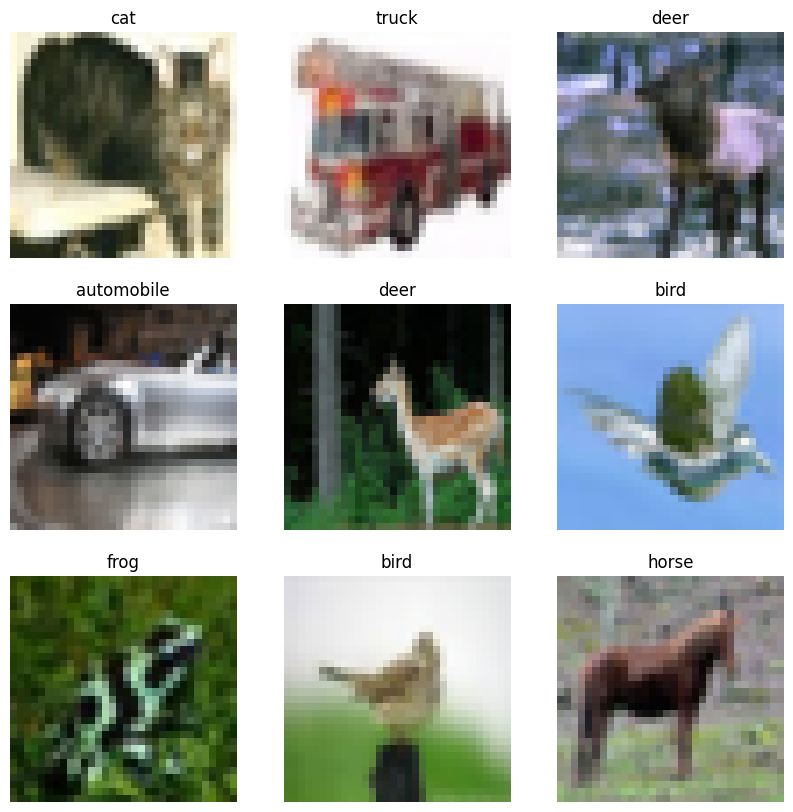

In [8]:
import matplotlib.pyplot as plt
import torch

figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(val2label[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

We define our parameters.

In [9]:
batch_size = 32
epochs = 50
learning_rate = 1e-3

Create our DataLoader.

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

We build our model.

In [12]:
from torch import nn

class CifarCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.25),
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.25),
        )
        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.25),
        )
        self.flatten = nn.Flatten()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=2048, out_features=128),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=128, out_features=10),
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.flatten(x)
        x = self.linear_layer(x)
        return x

In [13]:
model = CifarCNN().to(device)

Let's lee if the forward pass works.

In [14]:
img, label = next(iter(train_dataloader))

img = img.to(device)
logits = model(img)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)

print(f"Predicted class: {y_pred}")

Predicted class: tensor([3, 9, 9, 3, 9, 9, 9, 0, 3, 4, 3, 9, 8, 0, 3, 0, 7, 3, 0, 3, 6, 2, 2, 3,
        0, 7, 3, 9, 9, 2, 3, 2], device='cuda:0')


In [15]:
print(model)

CifarCNN(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.25, inplace=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

Define our loss function and optimization algorithm.

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Our training and test loop.

Note that we save the weights of our model everytime we achieve a new highscore accuracy. After the training, we can restore the best performing weights in case we overfitted our model.

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, best_result):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    if correct > best_result:
        print("New highscore! Saving model...\n")
        torch.save(model.state_dict(), 'best-model-parameters.pt')
        return correct
    print()
    return best_result

Start training!

In [18]:
best_result = 0.0
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    best_result = test_loop(test_dataloader, model, loss_fn, best_result)
print("Done!")

Epoch 1
-------------------------------
loss: 2.338603  [   32/50000]
loss: 1.896550  [ 3232/50000]
loss: 2.088956  [ 6432/50000]
loss: 1.992159  [ 9632/50000]
loss: 1.393033  [12832/50000]
loss: 1.341687  [16032/50000]
loss: 1.505417  [19232/50000]
loss: 1.319038  [22432/50000]
loss: 1.551045  [25632/50000]
loss: 1.406368  [28832/50000]
loss: 1.456651  [32032/50000]
loss: 1.363091  [35232/50000]
loss: 1.506295  [38432/50000]
loss: 1.559747  [41632/50000]
loss: 1.526213  [44832/50000]
loss: 1.166115  [48032/50000]
Test Error: 
 Accuracy: 58.4%, Avg loss: 1.154073
New highscore! Saving model...

Epoch 2
-------------------------------
loss: 1.423602  [   32/50000]
loss: 1.333626  [ 3232/50000]
loss: 1.044275  [ 6432/50000]
loss: 0.967204  [ 9632/50000]
loss: 1.140995  [12832/50000]
loss: 1.001956  [16032/50000]
loss: 0.957940  [19232/50000]
loss: 1.345837  [22432/50000]
loss: 1.013554  [25632/50000]
loss: 1.173164  [28832/50000]
loss: 1.138753  [32032/50000]
loss: 1.132075  [35232/50000

Load our best performin model.

In [ ]:
model.load_state_dict(torch.load("best-model-parameters.pt"))

<All keys matched successfully>

Let's check some predictions of our model on the test set.

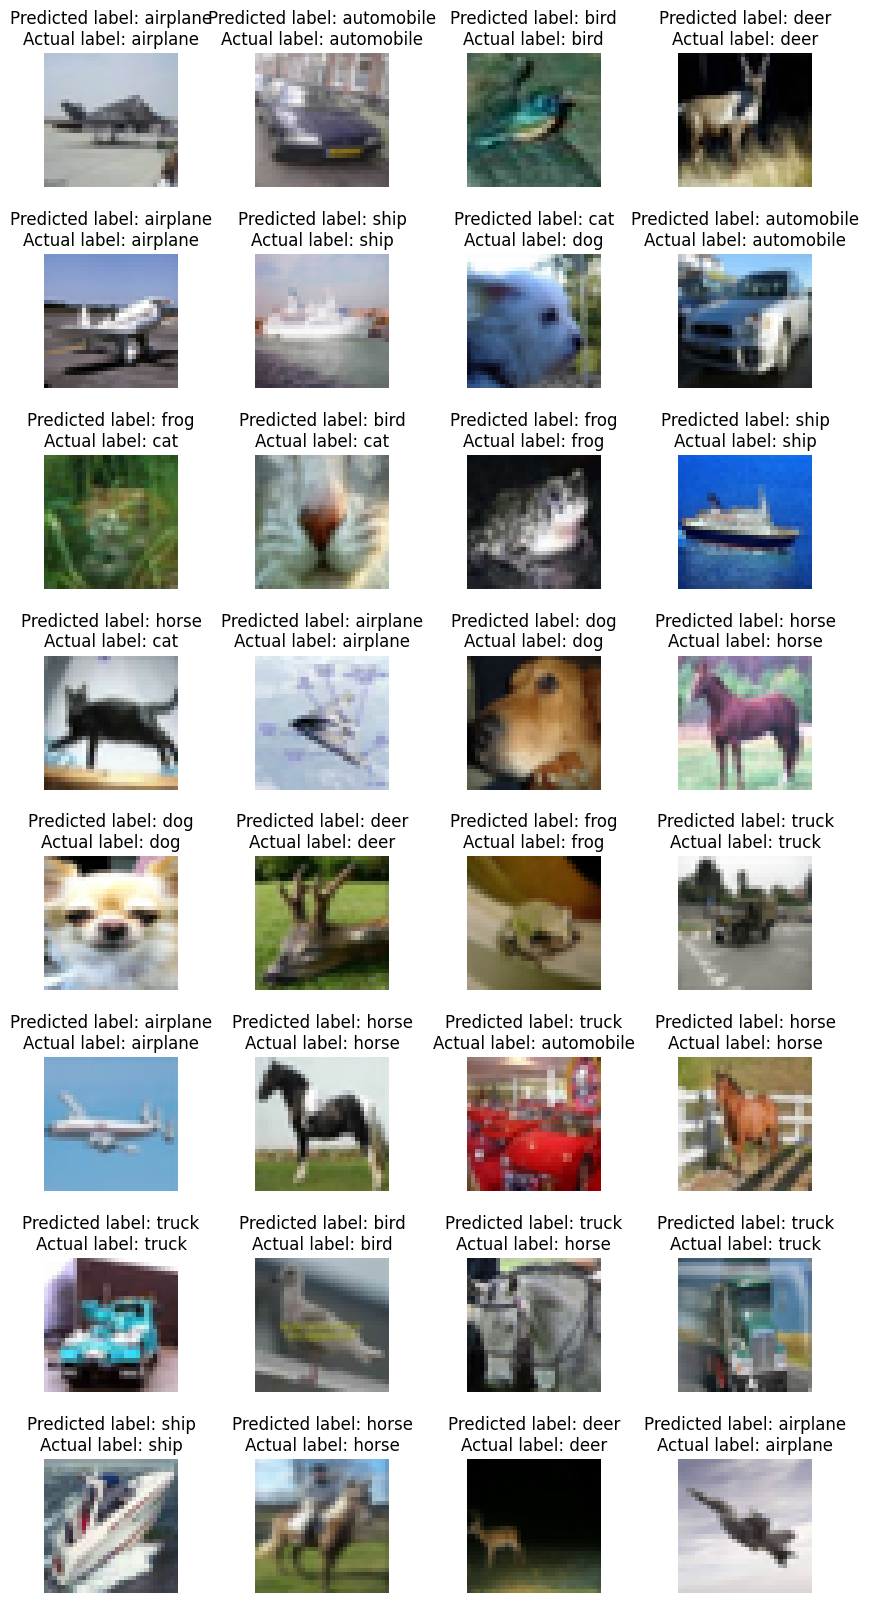

In [19]:
model.eval()

img, label = next(iter(test_dataloader))
img = img.to(device)
label = label.to(device)
predicted_label = model(img)

figure = plt.figure(figsize=(10, 20))
cols, rows = 4, 8
for i in range(0, cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"Predicted label: {val2label[predicted_label[i].argmax().item()]}\nActual label: {val2label[label[i].item()]}")
    plt.axis("off")
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    plt.imshow(img[i].permute(1, 2, 0).cpu())
plt.show()

Print the confusion matrix.

<Axes: >

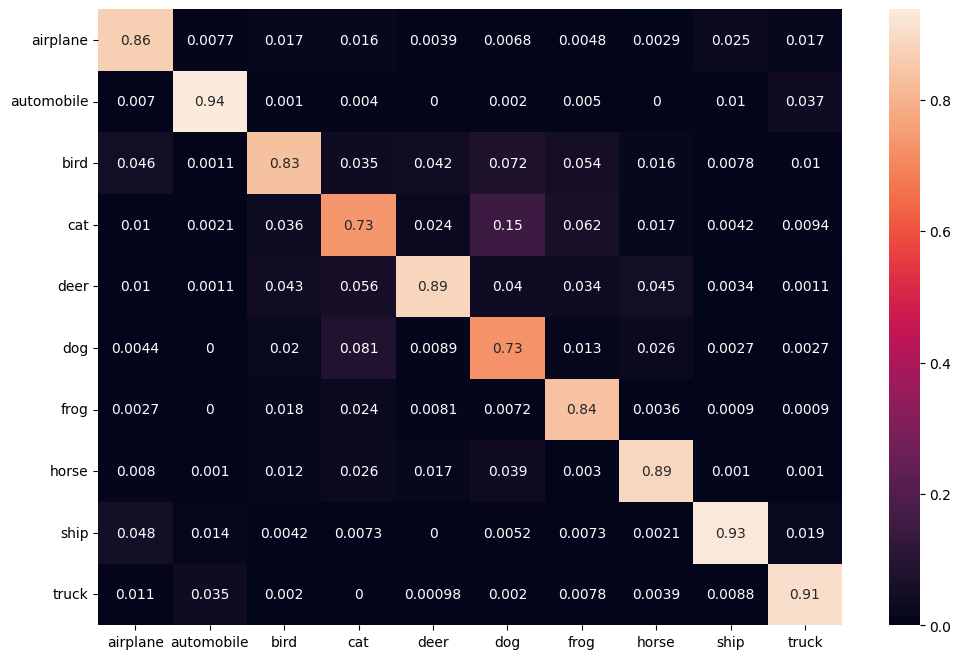

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    # iterate over test data
    for X, y in test_dataloader:

            X = X.to(device)
            y = y.to(device)
            output = model(X)

            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output)

            labels = y.data.cpu().numpy()
            y_true.extend(labels)

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=0)[:, None], index = [val2label[i] for i in range(10)],
                     columns = [val2label[i] for i in range(10)])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True)

Let's see if our model can successfully classify Lilo as a cat.

Lilo is a cat with p=1.000!


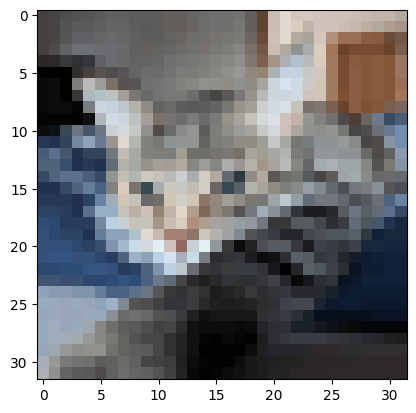

In [22]:
from PIL import Image
from torchvision import transforms

model.eval()

img = Image.open('lilo_small.png').convert('RGB')

transform = transforms.Compose([
                transforms.ToTensor(),
            ])
img_tensor = transform(img).to(device)

logit = model(img_tensor.unsqueeze(0))
pred_probab = nn.Softmax(dim=1)(logit)
y_prob = pred_probab.max()
label = (logit.squeeze().detach().argmax().item())

plt.imshow(img)

print(f"Lilo is a {val2label[label]} with p={y_prob.item():.3f}!")